Задача:

Считать данные  из [training.csv](task2/training.csv). Ответы на тестовой выборке [testing.csv](task2/testing.csv) не следует использовать ни в каких экспериментах, кроме финального.Проверить является ли ряд стационарным в широком смысле. Это можно сделать двумя способами:


  1. Провести визуальную оценку, отрисовав ряд и скользящую статистику(среднее, стандартное отклонение). Постройте график на котором будет отображен сам ряд и различные скользящие статистики.
  2. Провести тест Дики - Фуллера.
  Сделать выводы из полученных результатов. Оценить достоверность статистики.
  3. Разложить временной ряд на тренд, сезональность, остаток в соответствии с аддитивной, мультипликативной моделями. Визуализировать их, оценить стационарность получившихся рядов, сделать выводы.
  4. Проверить является ли временной ряд интегрированным порядка $k$. Если является, применить к нему модель ARIMA, подобрав необходимые параметры с помощью функции автокорреляции и функции частичной автокорреляции. Выбор параметров обосновать. Отобрать несколько моделей. Предсказать значения для тестовой выборки. Визуализировать их, посчитать r2 score для каждой из моделей. Произвести отбор наилучшей модели с помощью информационного критерия Акаике. Провести анализ получившихся результатов.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm #SARIMA
from sklearn.metrics import r2_score, mean_squared_error

sns.set_theme(style="whitegrid")


In [15]:
df_train = pd.read_csv('training.csv')
df_test = pd.read_csv('testing.csv')

date_col = 'Date'
value_col = 'Value'

def preprocess_data(df, date_col, value_col):
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(by=date_col)
    # устанавливаем столбец с датами как индекс
    df = df.set_index(date_col)
    df.index.freq = 'MS'
    return df[value_col]

# предобработка
ts_train = preprocess_data(df_train, date_col, value_col)
ts_test = preprocess_data(df_test, date_col, value_col)

print("Данные загружены и обработаны.")
print(f"Тренировочный ряд: {ts_train.shape[0]} наблюдений")
print(f"Тестовый ряд: {ts_test.shape[0]} наблюдений")

Данные загружены и обработаны.
Тренировочный ряд: 360 наблюдений
Тестовый ряд: 60 наблюдений


In [16]:
ts_train.min()

22.8331

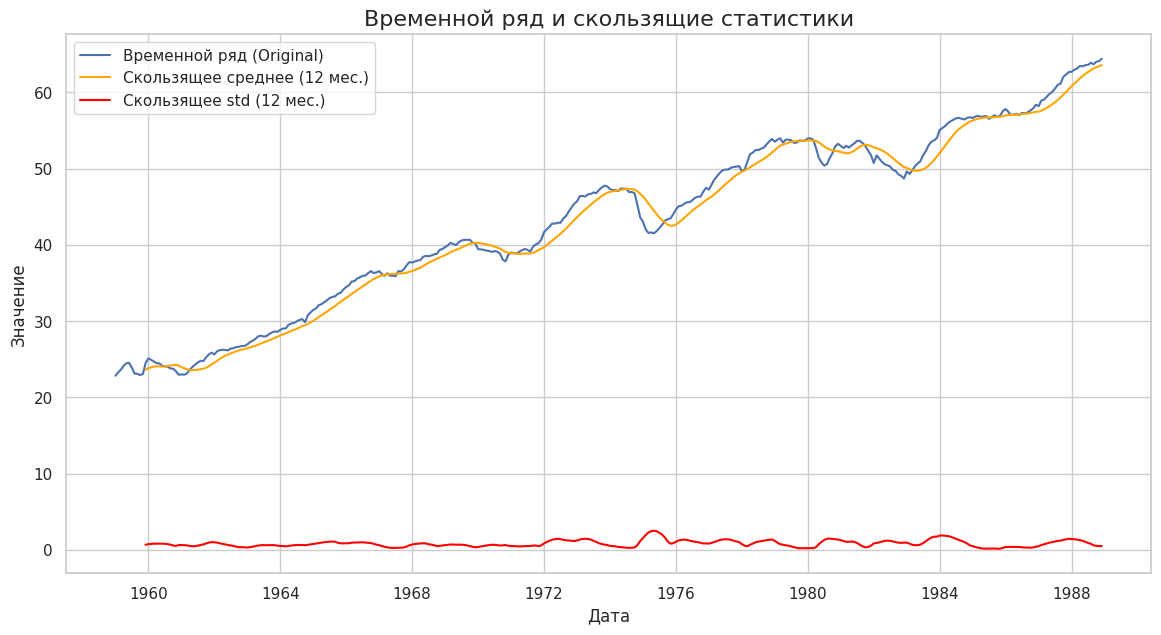

In [17]:
rolling_mean = ts_train.rolling(window=12).mean()
rolling_std = ts_train.rolling(window=12).std()

# графики
plt.figure(figsize=(14, 7))
sns.lineplot(data=ts_train, label='Временной ряд (Original)')
sns.lineplot(data=rolling_mean, label='Скользящее среднее (12 мес.)', color='orange')
sns.lineplot(data=rolling_std, label='Скользящее std (12 мес.)', color='red')
plt.title('Временной ряд и скользящие статистики', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

Ряд стационарен в широком смысле, если его математическое ожидание, дисперсия и автоковариация не зависят от времени.

ряд НЕ стационарен: скользящее среднее (оранжевая линия) имеет явный тренд(увеличение)

In [18]:
print('Результаты теста Дики-Фуллера для исходного ряда:')
dftest = adfuller(ts_train, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])

print(dfoutput)

print("\nКритические значения:")
for key, value in dftest[4].items():
    print(f'   {key}: {value:.4f}')

if dftest[1] <= 0.05:
    print("\n ВЫВОД (p-value <= 0.05)")
    print("Ряд, скорее всего, СТАЦИОНАРЕН(отвергаем H0)")
else:
    print("\n ВЫВОД (p-value > 0.05)")
    print("Ряд, скорее всего, НЕСТАЦИОНАРЕН(не можем отвергнуть H0)")

Результаты теста Дики-Фуллера для исходного ряда:
Test Statistic                  -0.253391
p-value                          0.931851
Lags Used                        5.000000
Number of Observations Used    354.000000
dtype: float64

Критические значения:
   1%: -3.4490
   5%: -2.8697
   10%: -2.5711

 ВЫВОД (p-value > 0.05)
Ряд, скорее всего, НЕСТАЦИОНАРЕН(не можем отвергнуть H0)


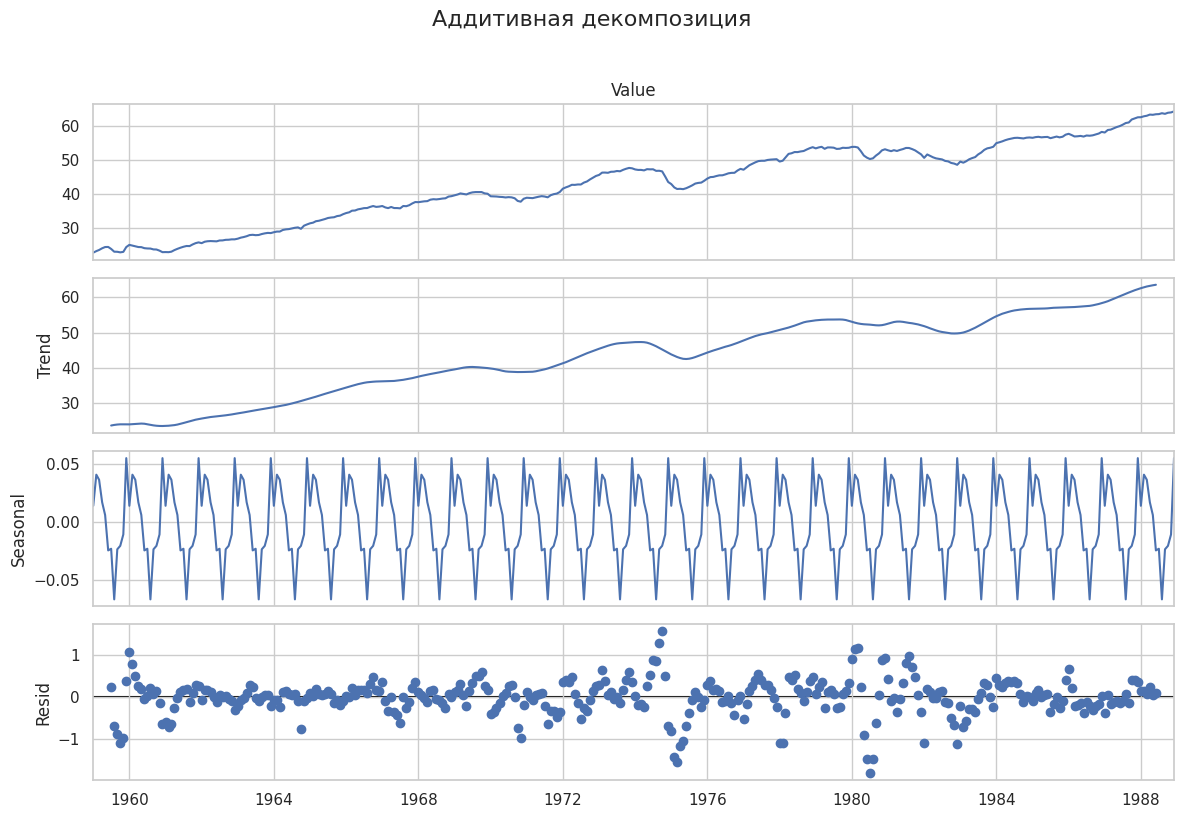

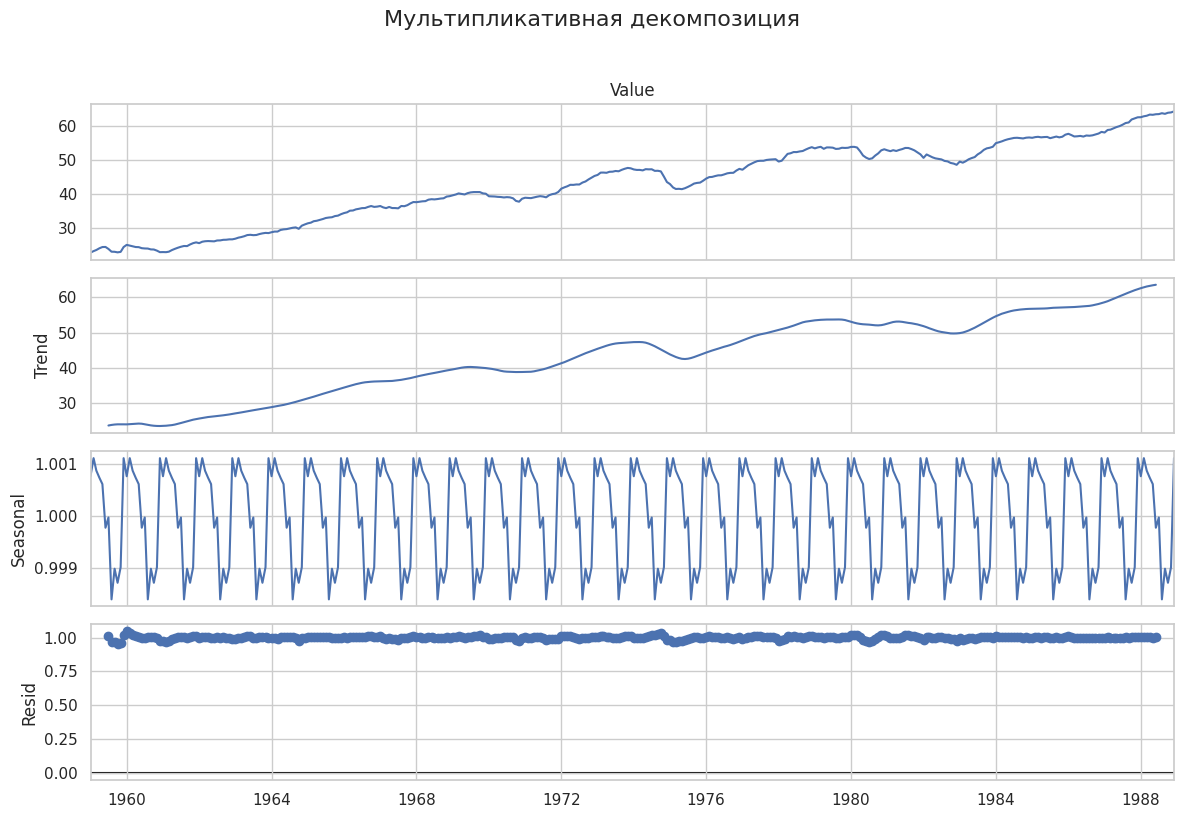

In [26]:
#декомпозиция
period = 12
#аддитивная модель
try:
    additive = seasonal_decompose(ts_train, model='additive', period=period)
    fig_add = additive.plot()
    fig_add.set_size_inches(12, 8)
    fig_add.suptitle('Аддитивная декомпозиция', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
except ValueError as e:
    print(f"Ошибка при аддитивной декомпозиции: {e}")
#мультипликативная модель
try:
    multiplicative = seasonal_decompose(ts_train, model='multiplicative', period=period)
    fig_mult = multiplicative.plot()
    fig_mult.set_size_inches(12, 8)
    fig_mult.suptitle('Мультипликативная декомпозиция', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
except ValueError as e:
    print(f"Ошибка при мультипликативной декомпозиции")

Тренд плавно растет(отсюда нестационарность).
Сезонность показывает регулярный, повторяющийся паттерн.
У остатков не наблюдается никакого паттерна, можно проверить на стационарность.

In [30]:
print("Проверка остатков (Resid) на стационарность")

if 'additive' in locals():
    print("\nРезультаты ADF для остатков АДДИТИВНОЙ модели:")
    # .dropna() нужен, т.к. при декомпозиции появляются NaN
    adf_resid_add = adfuller(additive.resid.dropna(), autolag='AIC')
    print(f'p-value: {adf_resid_add[1]:.4f}')
    if adf_resid_add[1] <= 0.05:
        print("Остатки стационарны.")
    else:
        print("Остатки нестационарны.")

if 'multiplicative' in locals():
    print("\nРезультаты ADF для остатков МУЛЬТИПЛИКАТИВНОЙ модели:")
    adf_resid_mult = adfuller(multiplicative.resid.dropna(), autolag='AIC')
    print(f'p-value: {adf_resid_mult[1]:.4f}')
    if adf_resid_mult[1] <= 0.05:
        print("Остатки стационарны.")
    else:
        print("Остатки нестационарны.")

Проверка остатков (Resid) на стационарность

Результаты ADF для остатков АДДИТИВНОЙ модели:
p-value: 0.0000
Остатки стационарны.

Результаты ADF для остатков МУЛЬТИПЛИКАТИВНОЙ модели:
p-value: 0.0000
Остатки стационарны.


In [29]:
ts_diff_1 = ts_train.diff(1).dropna()

print('Результаты ADF для первой разности (d=1):')
dftest_d1 = adfuller(ts_diff_1, autolag='AIC')
print(f'p-value: {dftest_d1[1]:.4f}')

if dftest_d1[1] <= 0.05:
    print("Ряд стал стационарным после 1-го дифференцирования. Используем d=1.")
    d = 1
    ts_stationary = ts_diff_1
else:
    #пробуем d=2 (вторая разность)
    print("\nПервая разность не дала стационарности, пробуем вторую (d=2).")
    ts_diff_2 = ts_train.diff(1).diff(1).dropna() # или ts_train.diff(2).dropna()

    print('Результаты ADF для второй разности (d=2):')
    dftest_d2 = adfuller(ts_diff_2, autolag='AIC')
    print(f'p-value: {dftest_d2[1]:.4f}')

    if dftest_d2[1] <= 0.05:
        print("Ряд стал стационарным после 2-го дифференцирования. Используем d=2.")
        d = 2
        ts_stationary = ts_diff_2
    else:
        print("Ряд не стал стационарным даже после d=2. ARIMA может не подойти.")
        d = 1
        ts_stationary = ts_diff_1

print(f"\nВыбранный параметр d = {d}")

Результаты ADF для первой разности (d=1):
p-value: 0.0000
Ряд стал стационарным после 1-го дифференцирования. Используем d=1.

Выбранный параметр d = 1


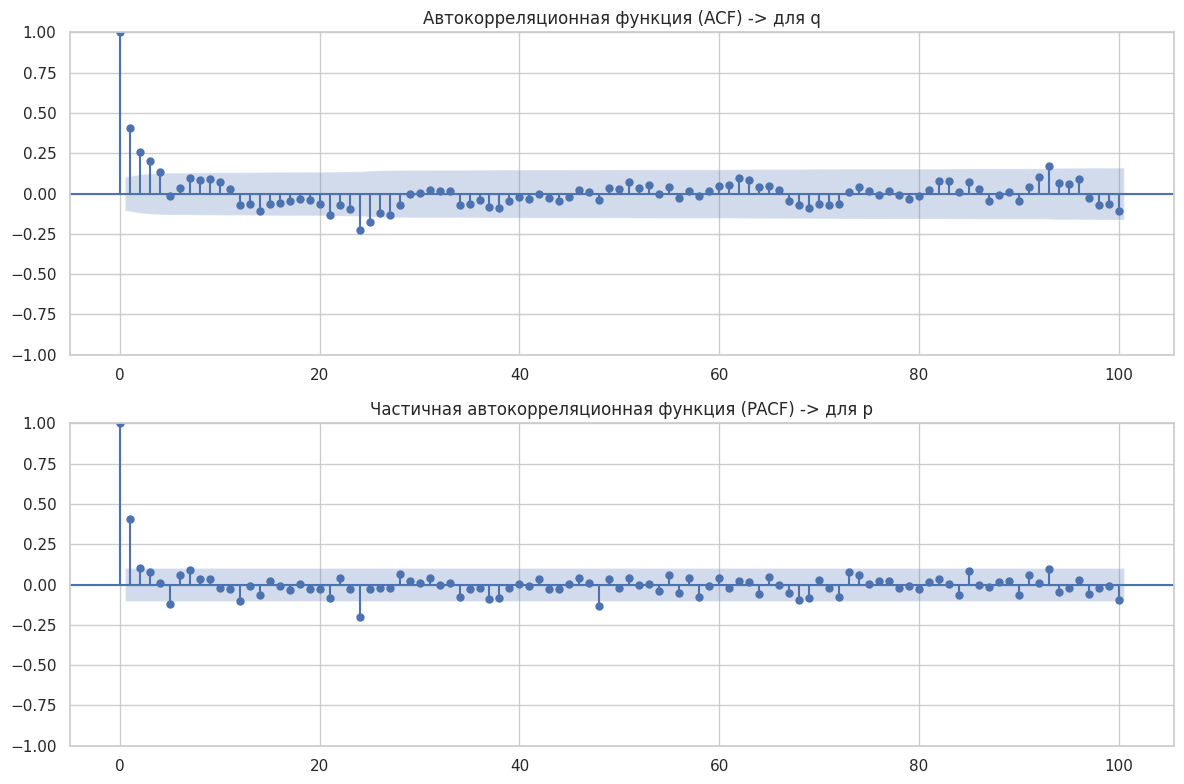

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(ts_stationary, lags=100, ax=ax1)
ax1.set_title('Автокорреляционная функция (ACF) -> для q')

plot_pacf(ts_stationary, lags=100, ax=ax2)
ax2.set_title('Частичная автокорреляционная функция (PACF) -> для p')

plt.tight_layout()
plt.show()

Графики PACF и ACF для ряда ($d=1, D=1$) указывают на следующие несезонные порядки для модели ARIMA:

PACF резко обрывается после лага 1(2). Следовательно, авторегрессия(зависимость от прошлых значений) $p=1$(или 2).

ACF резко обрывается после лага 3-5. Следовательно, скользящее среднее(зависимость от ошибок) $q=1$(или 2,  3,  4).

Для тестирования используем несезонные модели ARIMA(1, 1, 1), (2, 1, 1), (2, 1, 4).

Обучение моделей ARIMA
Модель ARIMA(1, 1, 1): AIC = 255.64
Модель ARIMA(2, 1, 1): AIC = 256.85
Модель ARIMA(2, 1, 4): AIC = 257.30
Лучшая модель по AIC
Лучшая модель: ARIMA(1, 1, 1) с AIC = 255.64
R2 (Test): -0.0245
RMSE (Test): 1.5749


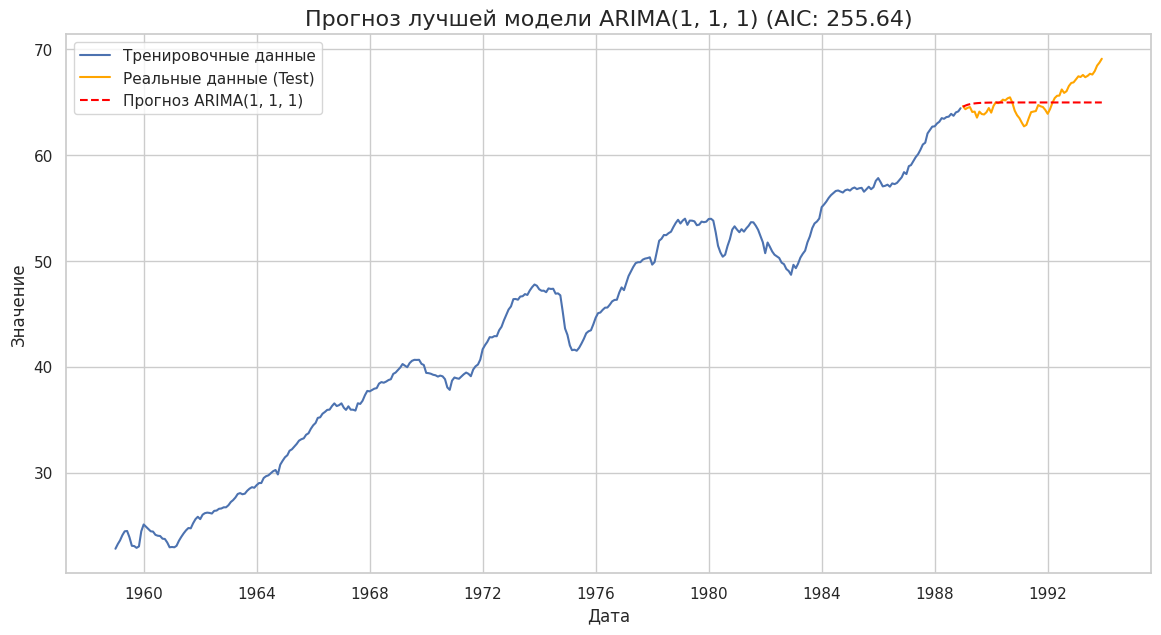

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -124.821
Date:                Tue, 04 Nov 2025   AIC                            255.641
Time:                        11:56:30   BIC                            267.291
Sample:                    01-01-1959   HQIC                           260.274
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7401      0.065     11.465      0.000       0.614       0.867
ma.L1         -0.3684      0.080     -4.599      0.000      -0.525      -0.211
sigma2         0.1173      0.006     20.413      0.0

In [34]:
#cписок моделей для проверки (p, d, q)
model_orders = [(1, 1, 1), (2, 1, 1), (2, 1, 4)]

best_aic = np.inf
best_model = None
best_order = None
results = {}

print("Обучение моделей ARIMA")

for order in model_orders:
    try:
        model = ARIMA(ts_train, order=order) #ts_train преобразованные тренировочные данные (вначале сделали)
        model_fit = model.fit()
        aic = model_fit.aic
        print(f"Модель ARIMA{order}: AIC = {aic:.2f}")

        # 'typ='levels'' важно, чтобы получить предсказание в исходном масштабе, а не дифференцированном
        pred = model_fit.predict(start=ts_test.index[0], end=ts_test.index[-1])
        r2 = r2_score(ts_test, pred)
        rmse = np.sqrt(mean_squared_error(ts_test, pred))
        results[order] = {'model_fit': model_fit, 'prediction': pred, 'aic': aic, 'r2': r2, 'rmse': rmse}

        if aic < best_aic:
            best_aic = aic
            best_model = model_fit
            best_order = order

    except Exception as e:
        print(f"Ошибка при обучении ARIMA{order}")
        continue

print(f"Лучшая модель по AIC")
print(f"Лучшая модель: ARIMA{best_order} с AIC = {best_aic:.2f}")

#результаты лучшей модели
best_pred = results[best_order]['prediction']
best_r2 = results[best_order]['r2']
best_rmse = results[best_order]['rmse']

print(f"R2 (Test): {best_r2:.4f}")
print(f"RMSE (Test): {best_rmse:.4f}")

plt.figure(figsize=(14, 7))
sns.lineplot(data=ts_train, label='Тренировочные данные')
sns.lineplot(data=ts_test, label='Реальные данные (Test)', color='orange')
sns.lineplot(data=best_pred, label=f'Прогноз ARIMA{best_order}', color='red', linestyle='--')
plt.title(f'Прогноз лучшей модели ARIMA{best_order} (AIC: {best_aic:.2f})', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

print(best_model.summary())

Как можно увидеть предсказание ARIMA достаточно ненадежны, модель плохо учитывает тренды и паттерны данных.

Поробуем подобрать лучшее предсказание с учетом сезонности, обратившись к ACF, PACF.

Сезонные (P, Q) (смотрим на лаги 12, 24...)

PACF (для P) - есть значимый пик на лаге 24, 48, 96. Это указывает на P=2, 4, 8.

ACF (для Q) - есть значимый пик на лаге 24, 96. Это указывает на Q=2, 8.

После нескольких запусков, мы увидим, что наилучший результат получается для P = 8, Q = 2, на них и обучим.

Обучение моделей SARIMA
Модель SARIMAX(1, 1, 1)x(8, 1, 2, 12): AIC = 217.21

Лучшая модель по AIC (Task 4.7)
Лучшая модель: SARIMAX(1, 1, 1)x(8, 1, 2, 12) с AIC = 217.21
R2 (Test) лучшей модели: 0.7232
RMSE (Test) лучшей модели: 0.8186


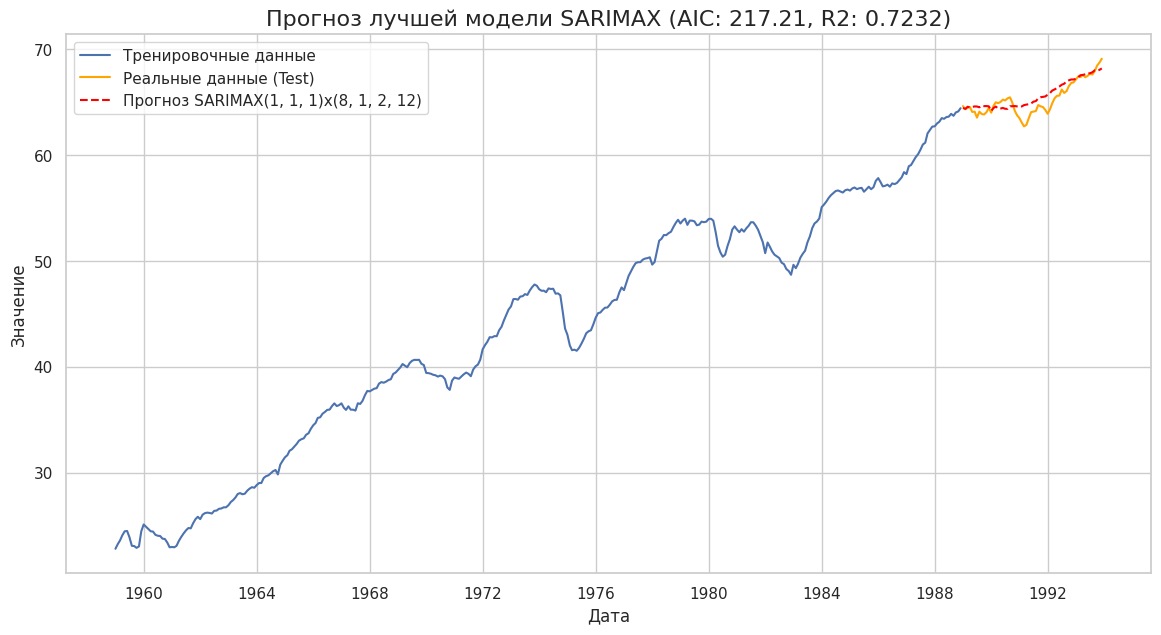


Сводка по лучшей модели
                                        SARIMAX Results                                        
Dep. Variable:                                   Value   No. Observations:                  360
Model:             SARIMAX(1, 1, 1)x(8, 1, [1, 2], 12)   Log Likelihood                 -95.603
Date:                                 Tue, 04 Nov 2025   AIC                            217.206
Time:                                         12:52:43   BIC                            262.985
Sample:                                     01-01-1959   HQIC                           235.631
                                          - 12-01-1988                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6281      0.097      6.506      

In [43]:
# (p, d, q) x (P, D, Q, m), m - сезонность
# эти параметры получились наилучшими
# для [ ((1, 1, 1), (4, 1, 2, 12))] не получилось предсказать спад
model_orders = [ ((1, 1, 1), (8, 1, 2, 12))]

best_aic = np.inf
best_model = None
best_order = None
results = {}

print("Обучение моделей SARIMA")

for order, s_order in model_orders:
    try:
        model = sm.tsa.statespace.SARIMAX(
            ts_train,
            order=order,
            seasonal_order=s_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        # disp=False, чтобы не выводить лог обучения
        model_fit = model.fit(maxiter=100,disp=False)
        aic = model_fit.aic
        print(f"Модель SARIMAX{order}x{s_order}: AIC = {aic:.2f}")
        #предсказание на тестовой выборке
        pred = model_fit.predict(start=ts_test.index[0], end=ts_test.index[-1], dynamic=False)
        r2 = r2_score(ts_test, pred)
        rmse = np.sqrt(mean_squared_error(ts_test, pred))

        results[(order, s_order)] = {'model_fit': model_fit, 'prediction': pred, 'aic': aic, 'r2': r2, 'rmse': rmse}

        #ищем лучшую модель по AIC
        if aic < best_aic:
            best_aic = aic
            best_model = model_fit
            best_order = (order, s_order)

    except Exception as e:
        print(f"Ошибка при обучении SARIMAX{order}x{s_order}: {e}")
        continue

print(f"\nЛучшая модель по AIC (Task 4.7)")
print(f"Лучшая модель: SARIMAX{best_order[0]}x{best_order[1]} с AIC = {best_aic:.2f}")

# результаты лучшей модели
best_pred = results[best_order]['prediction']
best_r2 = results[best_order]['r2']
best_rmse = results[best_order]['rmse']

print(f"R2 (Test) лучшей модели: {best_r2:.4f}")
print(f"RMSE (Test) лучшей модели: {best_rmse:.4f}")

plt.figure(figsize=(14, 7))
sns.lineplot(data=ts_train, label='Тренировочные данные')
sns.lineplot(data=ts_test, label='Реальные данные (Test)', color='orange')
sns.lineplot(data=best_pred, label=f'Прогноз SARIMAX{best_order[0]}x{best_order[1]}', color='red', linestyle='--')
plt.title(f'Прогноз лучшей модели SARIMAX (AIC: {best_aic:.2f}, R2: {best_r2:.4f})', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

print("\nСводка по лучшей модели")
print(best_model.summary())